In [20]:
import sys
import jax.numpy as jnp
import numpy as np
from trax import layers as tl
from trax.shapes import signature
from trax.layers import combinators as cb
from trax.layers.assert_shape import assert_shape

sys.path.insert(0, "../..")
from src.models.build import summary
from pathlib import Path
from src.data import data_tools

from src.settings import SiameseSettings

settings = SiameseSettings()


# load some data

In [21]:
url = settings.url
data_dir = settings.data_dir

data_tools.get_file(data_dir, settings.file, url)


100%|██████████| 3.80M/3.80M [00:01<00:00, 3.68MiB/s]


# get the paths

In [22]:
from src.data import data_tools

paths, _ = data_tools.iter_valid_paths(data_dir / settings.training, formats=[".pgm"])


Lets have a look at a file.
This are faces of 40 subjects, and every subject has 10 photos.

Shape: (112, 92)


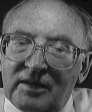

In [23]:
file = next(paths)
from PIL import Image

img = Image.open(file)
print(f"Shape: {np.array(img).shape}")
img


Images are shaped (112, 92, 1)

In [24]:
import numpy as np

rng = np.random.default_rng()
X = rng.random((32,) + np.array(img).shape + (1,))
X.shape


(32, 112, 92, 1)

The idea of the siamese model is to have an encoder that transforms images into vectors.
Our basemodel is a basic CNN

In [25]:
def Avg2D():
    return tl.Fn("Avg2D", lambda x: x.mean(axis=(1, 2)), n_out=1)


@assert_shape("bwhc->bd")
def Encoder(config) -> cb.Serial:
    model = cb.Serial(
        tl.Conv(config["filters1"], kernel_size=(3, 3), strides=(3, 3)),
        tl.Relu(),
        tl.Conv(config["filters2"], kernel_size=(3, 3), strides=(2, 2)),
        tl.Relu(),
        tl.Conv(config["filters3"], kernel_size=(3, 3), strides=(2, 2)),
        tl.Relu(),
        Avg2D(),
    )
    return model


config = {
    "filters1": 96,
    "filters2": 256,
    "filters3": 384,
}
encoder = Encoder(config)
encoder.init_weights_and_state(signature(X))
summary(encoder, X)


layer                   input                dtype     output               dtype 
(0) Conv                (32, 112, 92, 1)   (float64) | (32, 37, 30, 96)   (float32)
(1) Relu                (32, 37, 30, 96)   (float32) | (32, 37, 30, 96)   (float32)
(2) Conv                (32, 37, 30, 96)   (float32) | (32, 18, 14, 256)  (float32)
(3) Relu                (32, 18, 14, 256)  (float32) | (32, 18, 14, 256)  (float32)
(4) Conv                (32, 18, 14, 256)  (float32) | (32, 8, 6, 384)    (float32)
(5) Relu                (32, 8, 6, 384)    (float32) | (32, 8, 6, 384)    (float32)
(6) Avg2D               (32, 8, 6, 384)    (float32) | (32, 384)          (float32)


ShapeDtype{shape:(32, 384), dtype:float32}

As you can check, we start out with a batch of 32 images, each (112,92) big, with 1 channel.
Our model has three layers, and transforms the images into vectors of lenght 384.

The idea of the siamese model is to calculate the distance between the two.
We will subtract and calculate the L2 norm, $$\sqrt{||x_1 - x_2||^2}$$

This is a generalized form of the Pythagoras formula

In [26]:
x1 = rng.random((32, 8))
x2 = rng.random((32, 8))
yhat = rng.integers(0, 2, 32)
distance = np.linalg.norm(x1 - x2, axis=-1)
distance


array([1.07719866, 1.14299861, 1.02750944, 0.65954882, 0.98387584,
       1.02697084, 1.07833309, 0.99599219, 0.82441366, 1.1453552 ,
       1.46424912, 1.21094332, 1.54924209, 1.24016068, 0.72707926,
       1.16887726, 1.01208151, 1.17729566, 0.96513907, 0.92295388,
       1.12956337, 1.36923379, 1.07489065, 0.9027057 , 1.11131096,
       1.30398411, 0.7336572 , 1.26711052, 1.27269505, 0.96871354,
       1.04435153, 0.88830364])

Our aim is:
we want the images from the same class (the same person) to be close to each other, and images from different persons to be far away.

We do this with contrastive loss:
$$\hat{y} * d + (1-\hat{y}) * max(0, m - d)$$

where $m$ is the margin we choose as "close".
Let's implement this as a proper loss class.

In [27]:
class ContrastiveLoss:
    def __init__(self, margin: float = 1.0):
        self.margin = margin

    def __repr__(self) -> str:
        return "ContrastiveLoss"

    def __call__(self, y1, y2, yhat):
        distance = jnp.linalg.norm(y1 - y2, axis=-1)
        distance_ = jnp.clip(distance, 1e-14, 10)
        return jnp.mean(
            yhat * distance + (1 - yhat) * jnp.maximum(0, self.margin - distance)
        )


loss = ContrastiveLoss()
loss(x1, x2, yhat)


DeviceArray(0.6684706, dtype=float32)

With trax, creating a Siamese network is a piece of cake.

In [28]:
def Siamese(config):
    encoder = Encoder(config)
    model = cb.Parallel(encoder, encoder)
    return model


In [32]:
img1 = rng.random((32,) + np.array(img).shape + (1,))
img2 = rng.random((32,) + np.array(img).shape + (1,))
y = rng.random(32)
siamese = Siamese(config)
siamese.init_weights_and_state(signature((img1, img2)))
x1, x2 = siamese((img1, img2))
signature((x1, x2))


(ShapeDtype{shape:(32, 384), dtype:float32},
 ShapeDtype{shape:(32, 384), dtype:float32})

In [33]:
loss(x1, x2, y)

DeviceArray(0.4690957, dtype=float32)

All that is left to do is to create a proper dataloader, and to wrap everything in a trainloop.

Another strategy would be to use transfer learing;
e.g. if we load a pretrained resnet from torchvision, and slap on a final Dense layer, 
our training is probably faster and more accurate.